# Import Libraries 

In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np 
import seaborn as sns

# Load Dataset

In [2]:
dataset = pd.read_csv("Malware_Dataset.csv")

In [3]:
dataset.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


# Prepare the Dataset

In [4]:
## Drop Category, not needed. 

In [5]:
df = dataset.drop(['Category'], axis=1)

In [6]:
## make class 0 and 1 instead of malware and benign 
## malware = 1
## Bennign = 0 

In [7]:
df['Class'] = df['Class'].replace(['Malware', 'Benign'], [1, 0]) 

In [8]:
#### using a tree based model to determine feature importance - Done in data visualization file
#### Using Random Forest 
#### Choosing top 10 features based on feature importance 


In [9]:
dataset_top_10_features = pd.DataFrame()

In [10]:
## columns to copy 

top_ten_features_list = ['callbacks.ngeneric','callbacks.nanonymous', 'callbacks.ncallbacks', 'svcscan.nactive', 
                         'svcscan.interactive_process_services', 
                         'svcscan.shared_process_services','svcscan.fs_drivers','svcscan.kernel_drivers', 'svcscan.nservices',
                         'modules.nmodules', 'Class']

In [11]:
## creating new dataset using a for loop that iterates through the features of the original dataset, find the ones that 
## match in array of features and then copy the top 10 features to the new dataset. 

for feature in  top_ten_features_list: 
    dataset_top_10_features[feature] = df[feature]

In [12]:
## deleting random rows in dataset, to make the malware samples more anomolous. 
malware_samples_indices = dataset_top_10_features[dataset_top_10_features['Class'] == 1].index
num_rows_to_delete = int(0.8 * len(malware_samples_indices))
rows_to_delete = np.random.choice(malware_samples_indices, size=num_rows_to_delete, replace=False)



In [13]:
data = dataset_top_10_features.drop(rows_to_delete)

In [14]:
print(data['Class'].value_counts())

0    29298
1     5860
Name: Class, dtype: int64


# Split Dataset into Training and Test set

In [15]:
##Split dataset into X and Y values
## Because these models are unsupervised, labels are not needed for training 
# only used for evaluation at the end. 

In [16]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2, random_state=42)

In [18]:
accuracies = []
precisions = []
recalls = []
f1_scores = [] 

# Training And Evaluating Isolation Forest

In [19]:
Isolation_Forest_model=IsolationForest(max_samples= 100, n_estimators= 200, contamination=0.2, bootstrap = True)
Isolation_Forest_model.fit(Xtrain)

IsolationForest(bootstrap=True, contamination=0.2, max_samples=100,
                n_estimators=200)

In [20]:
predictions = Isolation_Forest_model.predict(Xtest)
print(predictions)

[ 1  1  1 ...  1  1 -1]


In [21]:
print(pd.value_counts(predictions))

 1    5779
-1    1253
dtype: int64


In [22]:
## map the predictions to 0 and 1 from -1 and 1
## map anomalies to 1 and normal instances to 0

In [23]:
predictions[predictions== 1] = 0
predictions[predictions== -1] = 1


In [24]:
print(pd.value_counts(predictions))

0    5779
1    1253
dtype: int64


In [25]:
Isolation_forest_classification_report = classification_report(predictions, ytest)
print(Isolation_forest_classification_report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5779
           1       0.86      0.80      0.83      1253

    accuracy                           0.94      7032
   macro avg       0.91      0.88      0.90      7032
weighted avg       0.94      0.94      0.94      7032



<Axes: >

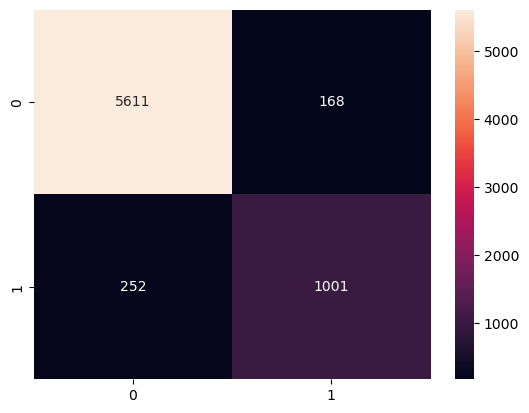

In [26]:
Isolation_forest_confusion_matrix = confusion_matrix(predictions, ytest)
sns.heatmap(Isolation_forest_confusion_matrix, fmt='2', annot=True)

In [27]:
Isolation_forest_accuracy = accuracy_score(predictions, ytest)
Isolation_forest_precision = precision_score(predictions, ytest)
Isolation_forest_recall = recall_score(predictions, ytest)
Isolation_forest_f1_score = f1_score(predictions, ytest)

print(Isolation_forest_accuracy)
print(Isolation_forest_precision)
print(Isolation_forest_recall)
print(Isolation_forest_f1_score)

0.9402730375426621
0.8562874251497006
0.7988826815642458
0.8265895953757226


In [28]:
accuracies.append(Isolation_forest_accuracy)
precisions.append(Isolation_forest_precision)
recalls.append(Isolation_forest_recall)
f1_scores.append(Isolation_forest_f1_score)

# Training and evaluating Local Outlier Factor 

In [29]:
# Local Outlier Factor 
Local_outlier_factor = LocalOutlierFactor(n_neighbors = 100, algorithm='auto', contamination=0.2, novelty=True)
Local_outlier_factor.fit(Xtrain)

LocalOutlierFactor(contamination=0.2, n_neighbors=100, novelty=True)

In [30]:
LOF_predictions = Local_outlier_factor.predict(Xtest)


In [31]:
LOF_predictions[LOF_predictions== 1] = 0
LOF_predictions[LOF_predictions== -1] = 1

print(pd.value_counts(LOF_predictions))

0    6688
1     344
dtype: int64


In [32]:
LOF_classification_report = classification_report(LOF_predictions, ytest)
print(LOF_classification_report)

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      6688
           1       0.16      0.53      0.24       344

    accuracy                           0.84      7032
   macro avg       0.56      0.69      0.58      7032
weighted avg       0.93      0.84      0.88      7032



<Axes: >

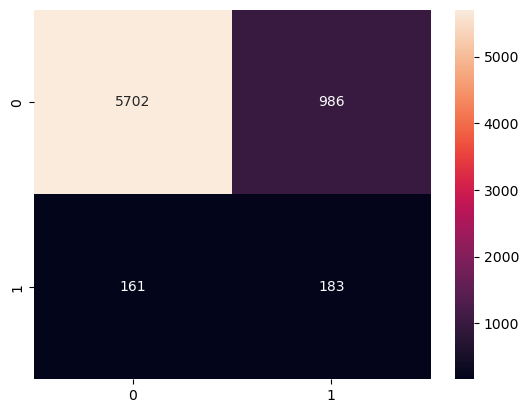

In [33]:
LOF_confusion_matrix = confusion_matrix(LOF_predictions, ytest)
sns.heatmap(LOF_confusion_matrix, fmt='2', annot=True)

In [34]:
LOF_accuracy = accuracy_score(LOF_predictions, ytest)
LOF_precision = precision_score(LOF_predictions, ytest)
LOF_recall = recall_score(LOF_predictions, ytest)
LOF_f1_score = f1_score(LOF_predictions, ytest)

print(LOF_accuracy)
print(LOF_precision)
print(LOF_recall)
print(LOF_f1_score)

0.8368885096700797
0.15654405474764757
0.5319767441860465
0.2419035029742234


In [35]:
accuracies.append(LOF_accuracy)
precisions.append(LOF_precision)
recalls.append(LOF_recall)
f1_scores.append(LOF_f1_score)

# Training and Evaluating One class SVM


In [36]:
one_class_svm = OneClassSVM()
one_class_svm.fit(Xtrain)

OneClassSVM()

In [37]:
one_class_svm_predictions=one_class_svm.predict(Xtest)

In [38]:
one_class_svm_predictions[one_class_svm_predictions== 1] = 0
one_class_svm_predictions[one_class_svm_predictions== -1] = 1

print(pd.value_counts(one_class_svm_predictions))

0    4022
1    3010
dtype: int64


In [39]:
SVM_classification_report = classification_report(one_class_svm_predictions, ytest)
print(SVM_classification_report)

              precision    recall  f1-score   support

           0       0.69      1.00      0.81      4022
           1       1.00      0.39      0.56      3010

    accuracy                           0.74      7032
   macro avg       0.84      0.69      0.69      7032
weighted avg       0.82      0.74      0.70      7032



<Axes: >

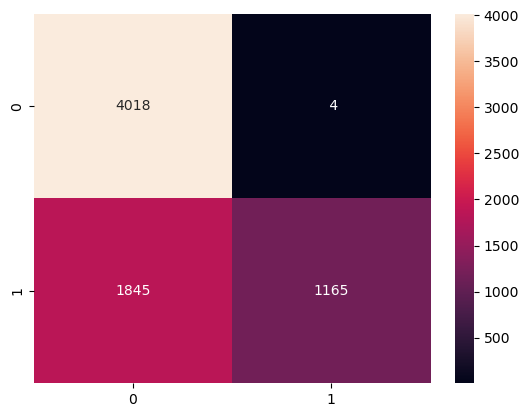

In [40]:
SVM_confusion_matrix = confusion_matrix(one_class_svm_predictions, ytest)
sns.heatmap(SVM_confusion_matrix, fmt='2', annot=True)

In [41]:
OC_SVM_accuracy = accuracy_score(one_class_svm_predictions, ytest)
OC_SVM_precision = precision_score(one_class_svm_predictions, ytest)
OC_SVM_recall = recall_score(one_class_svm_predictions, ytest)
OC_SVM_f1_score = f1_score(one_class_svm_predictions, ytest)

print(OC_SVM_accuracy)
print(OC_SVM_precision)
print(OC_SVM_recall)
print(OC_SVM_f1_score)

0.7370591581342435
0.9965782720273738
0.38704318936877075
0.5575496530270398


In [42]:
accuracies.append(OC_SVM_accuracy)
precisions.append(OC_SVM_precision)
recalls.append(OC_SVM_recall)
f1_scores.append(OC_SVM_f1_score)

# Evaluation Table

In [43]:
## All models have been trained and evaluated, now the final evaluation table will be generated

In [44]:
Evaluation_Table = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])


Evaluation_Table = pd.concat([Evaluation_Table, pd.DataFrame({
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1-Score": f1_scores
})], ignore_index=True)

Evaluation_Table.index = ['Isolation Forest', 'Local Outlier Factor', 'One Class SVM']
Evaluation_Table.index.names = ['Models']

In [45]:
Evaluation_Table

,Accuracy,Precision,Recall,F1-Score
Models,,,,
Isolation Forest,0.940273,0.856287,0.798883,0.826590
Local Outlier Factor,0.836889,0.156544,0.531977,0.241904
One Class SVM,0.737059,0.996578,0.387043,0.557550
